C:\Users\Harri\AppData\Local\Temp\ipykernel_1816\3745963999.py:157: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  coupling_sum = np.sum(Adj[i, j] * np.sin(theta[j] - theta[i]) for j in range(N))


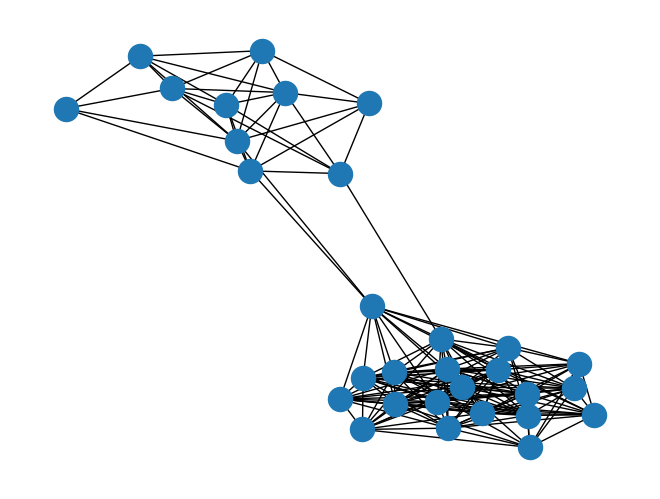

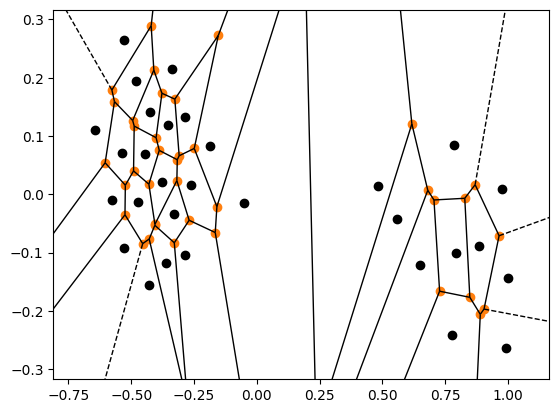

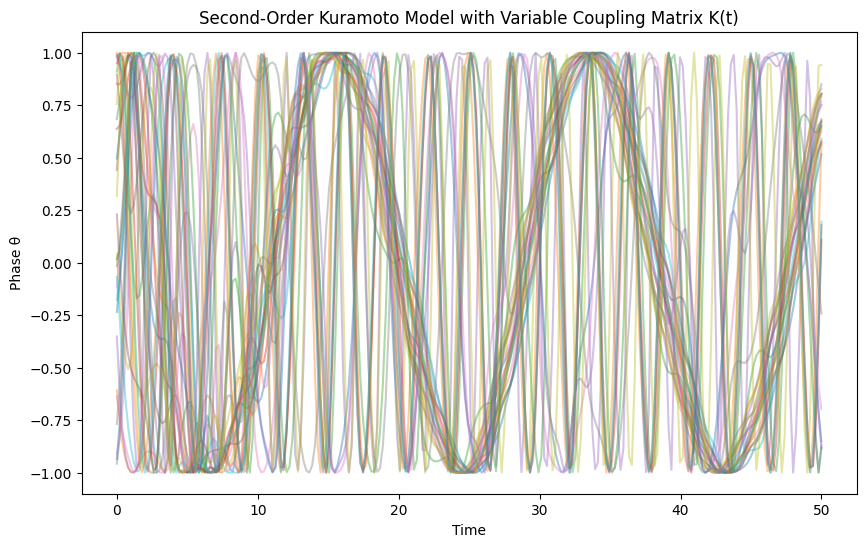

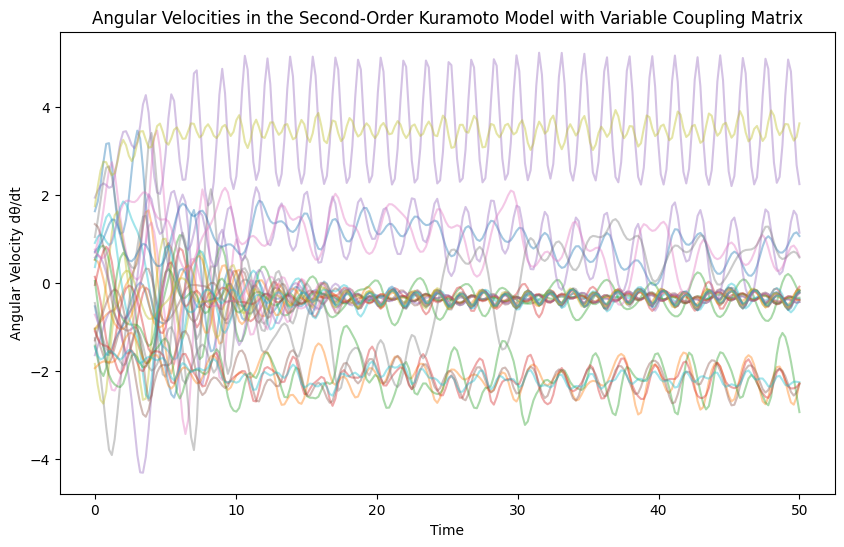

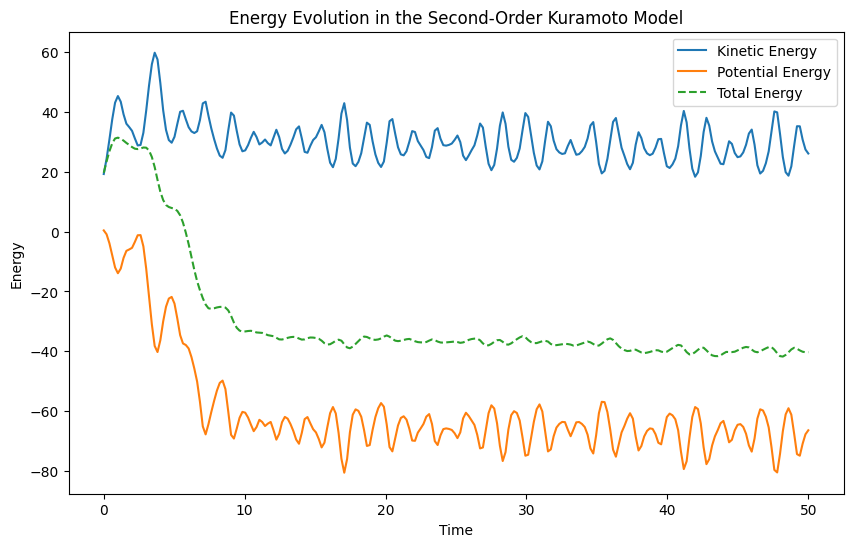

c:\Users\Harri\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(
C:\Users\Harri\AppData\Local\Temp\ipykernel_1816\3745963999.py:323: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\Harri\AppData\Local\Temp\ipykernel_1816\3745963999.py:392: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_path)
C:\Users\Harri\AppData\Local\Temp\ipykernel_1816\3745963999.py:445: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and 

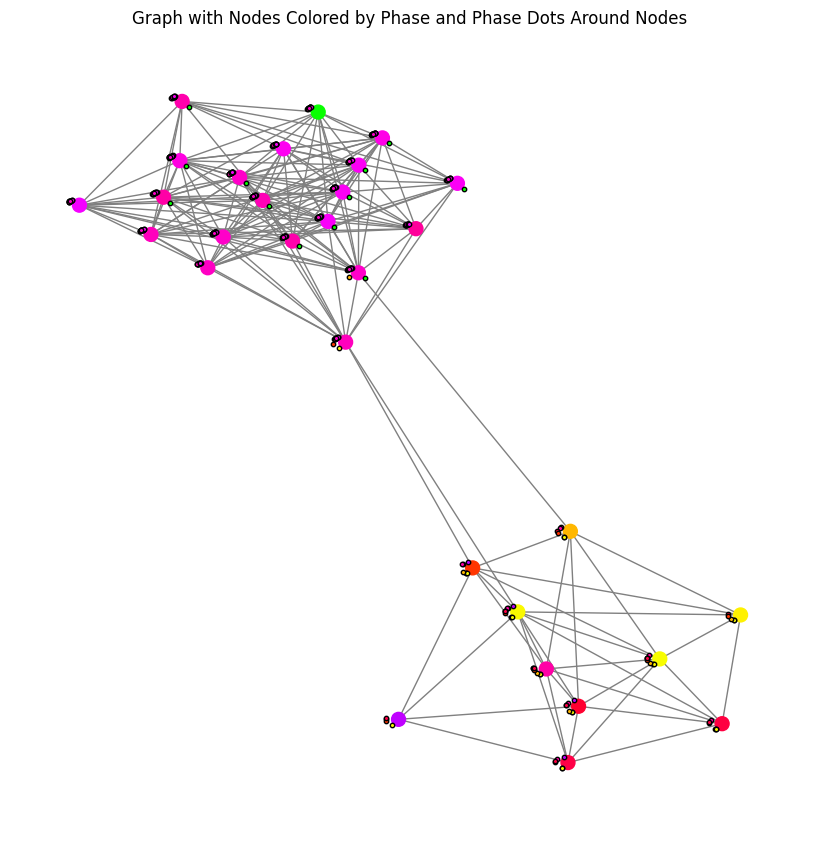

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from matplotlib.gridspec import GridSpec
import os
from itertools import combinations
import random
from scipy.stats import wasserstein_distance

def apollo_net(its):
    # Create an empty graph
    graph = nx.Graph()
    
    # Add nodes
    graph.add_nodes_from([1, 2, 3, 4,5,6,7])
    
    # Add edges to form a triangle
    graph.add_edges_from([(1, 2), (2, 3), (3, 1),(4,1),(4,2),(4,3),(5,4),(5,3),(5,1),(6,4),(6,3),(6,2),(7,1),(7,4),(7,2)])
    
    for itt in range(0,its):
        """
        For every node in the graph with the given degree, create new nodes for every 
        combination of two connected nodes, linking the new node to the original and the two nodes.
        
        Parameters:
            graph (networkx.Graph): The input graph.
            target_degree (int): The degree to search for.
        
        Returns:
            networkx.Graph: The modified graph.
        """
        # Identify all nodes with the specified degree
        target_nodes = [node for node in graph.nodes if graph.degree[node] == 3]
        
        # Process each target node
        for target_node in target_nodes:
            # Get neighbors of the target node
            neighbors = list(graph.neighbors(target_node))
            
            # Generate all combinations of 2 neighbors
            for combo in combinations(neighbors, 2):
                # Create a new node (use a unique identifier)
                new_node = f"new_node_{target_node}_{combo[0]}_{combo[1]}"
                
                # Add the new node to the graph
                graph.add_node(new_node)
                
                # Connect the new node to the target node and the two nodes in the combination
                graph.add_edges_from([
                    (new_node, target_node),
                    (new_node, combo[0]),
                    (new_node, combo[1])
                ])
    
    return graph

def Wasserstein(phases1, phases2):
    # Ensure phases are in [0, 2pi]
    phases1 = np.mod(phases1, 2 * np.pi)
    phases2 = np.mod(phases2, 2 * np.pi)
    
    # Compute the Wasserstein distance considering circularity
    distance = wasserstein_distance(phases1, phases2)
    
    return distance

def planar_draw(G):
    pos = nx.planar_layout(G)
     # Draw the graph
    nx.draw(G, node_color='lightblue', pos=pos, edge_color='gray', node_size=50, with_labels=False, alpha = 0.5)
    plt.title(f"Planar Graph")
    plt.show()

def GetAdj(G,k):
    graph_nx = G 
    adj = nx.to_numpy_array(graph_nx)*k
    try:
        planar_draw(G)
    except:
        nx.draw(graph_nx)
    return adj

def calculate_energy(theta, dtheta_dt, K_matrix, m, N):
    """
    Calculates the kinetic, potential, and total energy of the system.

    Parameters:
    theta : ndarray
        Phases of the oscillators
    dtheta_dt : ndarray
        Angular velocities of the oscillators
    K_matrix : ndarray
        Coupling matrix (NxN)
    m : float
        Inertia of the oscillators
    N : int
        Number of oscillators

    Returns:
    KE : float
        Total kinetic energy
    PE : float
        Total potential energy
    E : float
        Total energy
    """
    # Kinetic energy
    KE = 0.5 * m * np.sum(dtheta_dt**2)
    
    # Potential energy
    PE = 0
    for i in range(N):
        for j in range(i + 1, N):
            PE += -K_matrix[i, j] * np.cos(theta[j] - theta[i])
    
    # Total energy
    E = KE + PE
    return KE, PE, E

def kuramoto_ode_2nd_order_matrix(t, y, omega, Adj, m, gamma, N):
    """
    Defines the ODE system for the second-order Kuramoto model with a variable coupling matrix.

    Parameters:
    t : float
        Current time
    y : ndarray
        Array containing [theta, dtheta_dt] where:
        - theta: phases of the oscillators
        - dtheta_dt: angular velocities of the oscillators
    omega : ndarray
        Array of natural frequencies of the oscillators
    K_func : callable
        Function of time to determine the coupling matrix, K(t) (NxN matrix)
    m : float
        Inertia of the oscillators
    gamma : float
        Damping coefficient
    N : int
        Number of oscillators

    Returns:
    dydt : ndarray
        Derivatives [dtheta_dt, d2theta_dt2]
    """
    theta = y[:N]        # Phases of the oscillators
    dtheta_dt = y[N:]    # Angular velocities

    d2theta_dt2 = np.zeros(N)
   

    # Compute the angular acceleration for each oscillator
    for i in range(N):
        coupling_sum = np.sum(Adj[i, j] * np.sin(theta[j] - theta[i]) for j in range(N))
        d2theta_dt2[i] = ( omega[i] +coupling_sum - gamma * dtheta_dt[i]) / m # omega[i] +
    
    # Return [dtheta_dt, d2theta_dt2] as a flattened array
    return np.concatenate([dtheta_dt, d2theta_dt2])

def solve_kuramoto_2nd_order_matrix(T, theta0, omega, Adj, m, gamma, N, t_eval=None):
    """
    Solves the second-order Kuramoto model using solve_ivp with a variable coupling matrix.

    Parameters:
    T : float
        Final time for the integration
    theta0 : ndarray
        Initial phases of the oscillators
    omega : ndarray
        Natural frequencies of the oscillators
    K_func : callable
        Function of time to determine the coupling matrix, K(t) (NxN matrix)
    m : float
        Inertia of the oscillators
    gamma : float
        Damping coefficient
    N : int
        Number of oscillators
    t_eval : ndarray, optional
        Time points to evaluate the solution (default is None)

    Returns:
    result : OdeResult
        The result object containing the time points and solution.
    """
    # Initial angular velocities (set to zero or random)
    dtheta0 = omega#np.random.rand(N)*5 #np.zeros(N)
    # Initial condition vector [theta0, dtheta0]
    y0 = np.concatenate([theta0, dtheta0])
    
    # Time span
    t_span = (0, T)

    # Solving the ODE system
    result = solve_ivp(
        fun=kuramoto_ode_2nd_order_matrix, 
        t_span=t_span, 
        y0=y0, 
        args=(omega, Adj, m, gamma, N),
        t_eval=t_eval, 
        method='RK45'
    )
    
    # Calculate energies at each time step
    KE_values, PE_values, E_values = [], [], []
    for k in range(len(result.t)):
        theta = result.y[:N, k]
        dtheta_dt = result.y[N:, k]
        KE, PE, E = calculate_energy(theta, dtheta_dt, Adj, m, N)
        KE_values.append(KE)
        PE_values.append(PE)
        E_values.append(E)

    return result, np.array(KE_values), np.array(PE_values), np.array(E_values)

def plot_graph_frame(G, pos, adj, phases, nats, frame_path,timestep):
    """
    Create and save a graph visualization frame with fixed node positions and varying node phases.

    Parameters:
    - G (networkx.Graph): The graph object created from the adjacency matrix.
    - pos (dict): Precomputed positions for the nodes.
    - adj_matrix (2D list or numpy array): Constant adjacency matrix for the graph.
    - node_phases (list): Phases (in radians, 0 to 2π) for each node.
    - frame_path (str): Path to save the frame image.
    """
    # # Normalize the phases and map to a colormap
    # colormap = plt.get_cmap('hsv')
    
    # normalized_phases = [(phase + np.pi) % (2 * np.pi) - np.pi for phase in phases]
    
    # colormap_input = {node: (normalized_phases[node] + np.pi) / (2 * np.pi) for node in G.nodes()}
    # node_colors = [colormap(colormap_input[node]) for node in G.nodes()]
    
    

    # fig = plt.figure(figsize=(8, 8))
    # # Calculate node sizes based on the degree (number of edges)
    # node_sizes = [25 * G.degree(node) for node in G.nodes()]  # Scale factor to adjust node size
    
    # # Draw nodes, edges, and labels using fixed positions
    # ax0 = fig.add_subplot()
    # ax0.set_title(f"Graph t = {timestep}")
    # nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, edge_color ='gray', alpha=1, ax=ax0,cmap = colormap)
    # # nx.draw_networkx_edges(G, pos, edge_color="black",alpha = 0.7, width=1, ax=ax0)
    # # nx.draw_networkx_labels(G, pos, font_size=12, font_color='black', ax=ax0)
    # ax0.annotate(f"Timestep: {timestep}",xy=(20,20))
    
    # # Add phase dots around each node
    # for i, (node, (x, y)) in enumerate(pos.items()):
        
    #     # Get phase angle
    #     for j in range(0,len(pos.items())):
    #         if G.has_edge(node,j):
    #             phase = normalized_phases[j]                # Calculate dot position relative to the node
    #             dot_x = x + 0.025*np.cos(phase)
    #             dot_y = y + 0.025*np.sin(phase)
    #             # Plot the dot
    #             plt.scatter(dot_x, dot_y, color=node_colors[j], s=50, edgecolor='k', zorder=3)
    # # Colorbar for node phases
    # node_phase_sm = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(vmin=-np.pi, vmax=np.pi))
    # node_phase_sm.set_array([])
    # cbar1 = plt.colorbar(node_phase_sm, ax=plt.gca(), ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    # cbar1.ax.set_yticklabels(['-pi', '-pi/2', '0', 'pi/2', 'pi'])
    # cbar1.set_label(f"$sin(\theta)$")
    # Normalize the phases and map to a colormap
    colormap = plt.get_cmap('hsv')

    normalized_phases = [(phase + np.pi) % (2 * np.pi) - np.pi for phase in phases]
    
    # # Wasserstein between things
    # for i, (node) in enumerate(pos.items()):
    #     # Make dist of phases
    #     phases1 = np.array([])
    #     for ii in range(0,len(pos.items())):
    #         if G.has_edge(i,ii):
    #             phases1 = np.append(phases1,normalized_phases[ii])
    #     # Check each connected node and make it's phase distribution        
    #     for j in G.nodes:#range(0,len(pos.items())):
    #         if G.has_edge(node,j):
    #             # Get Phases of J's neighbours
    #             phases2 = np.array([])
    #             for ii in range(0,len(pos.items())):
    #                 if G.has_edge(j,ii):
    #                     phases2 = np.append(phases2,normalized_phases[ii])
                
    #             node_wass = Wasserstein(phases1,phases2)
        
    
    colormap_input = {node: (normalized_phases[node] + np.pi) / (2 * np.pi) for node in G.nodes()}
    node_colors = [colormap(colormap_input[node]) for node in G.nodes()]
    
    # Plot the graph with node colors based on their phases
    plt.figure(figsize=(8, 8))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color=node_colors,
        edge_color='gray',
        node_size=50,
        cmap=colormap,
    )

     # Add phase dots around each node
    for i, (node, (x, y)) in enumerate(pos.items()):
        
        # Get phase angle
        for j in G.nodes:#range(0,len(pos.items())):
            if G.has_edge(node,j):
                phase = normalized_phases[j]                # Calculate dot position relative to the node
                dot_x = x + 0.02*np.cos(phase)
                dot_y = y + 0.02*np.sin(phase)
                # Plot the dot
                plt.scatter(dot_x, dot_y, color=node_colors[j], s=10, edgecolor='k', zorder=3)

    plt.title("Graph with Nodes Colored by Phase and Phase Dots Around Nodes")
    plt.axis('off')
    # Save the frame
    plt.tight_layout()
    plt.savefig(frame_path)
    plt.close()

def plot_phase_nat_frame(node_phases, phase_hist, nat_hist, frame_path,timestep):
     # First extra plot: Line plot of node phases over time
    phase_hist = np.sin(phase_hist)
    fig = plt.figure(figsize=(8, 8)) 
    gs = GridSpec(2, 1, height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"Node Phases Over Time | t = {timestep}")
    for node_idx in range(len(node_phases)):
        #print(np.shape(phase_hist))
        ax1.plot([t[node_idx] for t in phase_hist], label=f"Node {node_idx}")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Phase (radians)")
    ax1.set_ylim(-1,1)
    
    
    
    # Second extra plot: Bar plot of current phase change magnitudes
    ax2 = fig.add_subplot(gs[1])
    # Plotting the angular velocities of each oscillator
    for node_idx in range(len(node_phases)):
        #print(np.shape(nat_hist))
        ax2.plot([t[node_idx] for t in nat_hist], label=f"Node {node_idx}")
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Angular Velocity dθ/dt')
    ax2.set_title('Angular Velocities in the Second-Order Kuramoto Model with Variable Coupling Matrix')
    # ax2.legend(loc="upper right", fontsize=8)
    

    # Save the frame
    plt.tight_layout()
    plt.savefig(frame_path)
    plt.close()
    
def create_graph_gif(adj_matrix, node_phases_list, nats,output_path, duration=0.5):
    """
    Create a GIF of graphs over time with a fixed adjacency matrix, fixed node positions, and varying node phases.

    Parameters:
    - adj_matrix (2D array): Constant adjacency matrix for the graph.
    - node_phases_list (list of lists): List of node phase lists (in radians, 0 to 2π) for each time point.
    - output_path (str): Path to save the output GIF.
    - duration (float): Duration of each frame in seconds.
    """
    frames_dir = "graph_frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Create a single graph object from the fixed adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))
    
    # Precompute node positions (fixed layout)
    pos = nx.spring_layout(G, seed=42)  # Fix the seed for consistent layout across frames
    frame_paths = []
   
    # Create a frame for each time point

    for t, (node_phases,nats) in enumerate(zip(node_phases_list,nats)):
      
        
        frame_path = os.path.join(frames_dir, f"frame_{t}.png")
        plot_graph_frame(G, pos, adj_matrix, node_phases, nats, frame_path,t)
        frame_paths.append(frame_path)

    # Create GIF using imageio
    with imageio.get_writer(output_path, mode='I', duration=duration) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    # # Clean up the frames directory
    # for frame_path in frame_paths:
    #     os.remove(frame_path)
    #     os.rmdir(frames_dir)
    # Clean up the frames directory
    for frame_path in frame_paths:
        os.remove(frame_path)
    for filename in os.listdir(frames_dir):
        file_path = os.path.join(frames_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
            
def create_plot_gif(adj_matrix, node_phases_list, nats,output_path, duration=0.5):
    """
    Create a GIF of graphs over time with a fixed adjacency matrix, fixed node positions, and varying node phases.

    Parameters:
    - adj_matrix (2D array): Constant adjacency matrix for the graph.
    - node_phases_list (list of lists): List of node phase lists (in radians, 0 to 2π) for each time point.
    - output_path (str): Path to save the output GIF.
    - duration (float): Duration of each frame in seconds.
    """
    frames_dir = "plot_frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Create a single graph object from the fixed adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))
    
    # Precompute node positions (fixed layout)
    pos = nx.spring_layout(G, seed=42)  # Fix the seed for consistent layout across frames
    frame_paths = []
   
    # Create a frame for each time point
    nats_hist = [] 
    phase_hist = []
    for t, (node_phases,nats) in enumerate(zip(node_phases_list,nats)):
        nats_hist.append(nats)
        phase_hist.append(node_phases)
        frame_path = os.path.join(frames_dir, f"frame_{t}.png")
        plot_phase_nat_frame(node_phases, phase_hist, nats_hist,frame_path,t)
        frame_paths.append(frame_path)

    # Create GIF using imageio
    with imageio.get_writer(output_path, mode='I', duration=duration) as writer:
        for frame_path in frame_paths:
            image = imageio.imread(frame_path)
            writer.append_data(image)

    # # Clean up the frames directory
    # for frame_path in frame_paths:
    #     os.remove(frame_path)
    #     os.rmdir(frames_dir)
    # Clean up the frames directory
    for frame_path in frame_paths:
        os.remove(frame_path)
    for filename in os.listdir(frames_dir):
        file_path = os.path.join(frames_dir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e)) 

def plot_colored_graph(adj_matrix, node_phases):
    """
    Create a NetworkX graph from an adjacency matrix and node phases (0 to 2π).
    Nodes are colored based on their phase, and edges are colored based on the adjacency matrix entries.

    Parameters:
    - adj_matrix (2D list or numpy array): Adjacency matrix representing the graph
    - node_phases (list): List of phases (in radians, from 0 to 2π) corresponding to each node

    Returns:
    - G (networkx.Graph): The generated graph
    """

    # Create the graph from the adjacency matrix
    G = nx.from_numpy_array(np.array(adj_matrix))

    # Normalize node phases to the range [0, 1] for the hsv colormap
    normalized_phases = [phase  for phase in node_phases] #% (2 * np.pi)) / (2 * np.pi)
    node_colors = [plt.cm.hsv(phase) for phase in normalized_phases]

    # Determine edge colors based on adjacency matrix entries
    edge_weights = [adj_matrix[u][v] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0
    normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]
    edge_colors = [plt.cm.viridis(weight) for weight in normalized_weights]

    # Plotting
    plt.figure(figsize=(8, 8))
    try:
        pos = nx.planar_layout(G)
    except:
        pos = nx.spring_layout(G)  # Use spring layout for better visualization

    # Draw nodes with colors based on phases
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=10, alpha=0.5)

    # Draw edges with colors based on adjacency matrix entries
    edges = nx.draw_networkx_edges(G, pos, edge_color="black", width=2)


    # Add colorbar for node phases
    node_phase_sm = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(vmin=0, vmax=2 * np.pi))
    node_phase_sm.set_array([])
    cbar1 = plt.colorbar(node_phase_sm, ax=plt.gca(), ticks=[0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    cbar1.ax.set_yticklabels(['0', 'π/2', 'π', '3π/2', '2π'])
    cbar1.set_label('Node Phase (radians)')

    # Add colorbar for edge weights
    edge_weight_sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
    edge_weight_sm.set_array([])
    cbar2 = plt.colorbar(edge_weight_sm, ax=plt.gca())
    cbar2.set_label('Edge Weight')

    plt.title("Graph with Colored Nodes (Phases) and Edges (Weights)")
    plt.show()
    
    return G

def GraphGif(adj,phases,nats,gif_query):
    if gif_query == False:
       return
    else:
        create_graph_gif(adj, np.transpose(phases),np.transpose(nats), "graph_animation.gif", duration=0.5)
        create_plot_gif(adj, np.transpose(phases),np.transpose(nats), "plot_animation.gif", duration=0.5)

def plot_graph_with_phases_as_colors(graph, phases, colormap_name='hsv'):
    """
    Plot a NetworkX graph where each node's color is determined by its phase,
    and each node has a dot around it at a position determined by the phase.

    Parameters:
        graph (networkx.Graph): The graph to plot.
        phases (dict): A dictionary mapping nodes to phases in radians.
        colormap_name (str): Name of the matplotlib colormap.
    """
    # Get positions for the graph layout
    pos = nx.spring_layout(graph)
    
    # Normalize the phases and map to a colormap
    colormap = plt.get_cmap(colormap_name)

    normalized_phases = [(phase + np.pi) % (2 * np.pi) - np.pi for phase in phases]
    
    colormap_input = {node: (normalized_phases[node] + np.pi) / (2 * np.pi) for node in graph.nodes()}
    node_colors = [colormap(colormap_input[node]) for node in graph.nodes()]
    
    # Plot the graph with node colors based on their phases
    plt.figure(figsize=(8, 8))
    nx.draw(
        graph,
        pos,
        with_labels=False,
        node_color=node_colors,
        edge_color='gray',
        node_size=100,
        cmap=colormap,
    )

     # Add phase dots around each node
    for i, (node, (x, y)) in enumerate(pos.items()):
        
        # Get phase angle
        for j in G.nodes:# range(0,len(pos.items())):
            if G.has_edge(node,j):
                phase = normalized_phases[j]                # Calculate dot position relative to the node
                dot_x = x + 0.015*np.cos(phase)
                dot_y = y + 0.015*np.sin(phase)
                # Plot the dot
                plt.scatter(dot_x, dot_y, color=node_colors[j], s=10, edgecolor='k', zorder=3)

    plt.title("Graph with Nodes Colored by Phase and Phase Dots Around Nodes")
    plt.axis('off')
    plt.show()
     
def make_graphs_disjoint(graph1, graph2):
    """
    Makes two graphs disjoint by relabeling the nodes of the second graph with an offset.
    
    Args:
        graph1 (nx.Graph): The first graph.
        graph2 (nx.Graph): The second graph.

    Returns:
        tuple: Two disjoint graphs.
    """
    # Calculate the offset based on the number of nodes in graph1
    offset = max(graph1.nodes) + 1 if len(graph1.nodes) > 0 else 0
    # Relabel nodes in graph2 with the offset
    graph2_disjoint = nx.relabel_nodes(graph2, lambda x: x + offset)
    return graph1, graph2_disjoint

def join_graphs_with_probability(graph1, graph2, p):
    """
    Connects two disjoint graphs by randomly adding edges between nodes of the first graph and the second graph
    with a given probability `p`.
    
    Args:
        graph1 (nx.Graph): The first graph.
        graph2 (nx.Graph): The second graph.
        p (float): The probability of adding an edge between a node in graph1 and a node in graph2.

    Returns:
        nx.Graph: A new graph containing both graph1 and graph2 with added edges.
    """
    # Make the graphs disjoint
    graph1, graph2 = make_graphs_disjoint(graph1, graph2)

    
    
    # Create a new graph to combine graph1 and graph2
    combined_graph = nx.compose(graph1, graph2)
    
    # Get node sets of each graph
    nodes_g1 = list(graph1.nodes)
    nodes_g2 = list(graph2.nodes)
    
    # Add edges with probability p
    for node1 in nodes_g1:
        for node2 in nodes_g2:
            if random.random() < p:
                combined_graph.add_edge(node1, node2)
    
    return combined_graph

if __name__ == "__main__":
    res = 250
    T = 50  # Simulation time
    m = 1.0 # Inertia of the oscillators
    gamma = 0.5 # Damping coefficient
    np.random.seed(42)  # For reproducibility
    
    N = 25# No. nodes
    k = 0.5# Coupling strength
    con = 0.3# erdos connectivity probability
    var,mean = 0.7, 0
    #G = graph_nx = nx.erdos_renyi_graph(n=N, p=con) # p=1 -> all-to-all connectivity
    
    # G = apollo_net(1)
    
    # Create graphs
    G1 = nx.erdos_renyi_graph(20, 0.75)
    G2 = nx.erdos_renyi_graph(10, 0.75)
    G3 = nx.erdos_renyi_graph(10, 0.75)
    G4 = nx.erdos_renyi_graph(30, 0.75)
    G5 = nx.erdos_renyi_graph(20, 0.75)
    G6 = nx.erdos_renyi_graph(20, 0.75)
    G7 = nx.erdos_renyi_graph(20, 0.75)
    G8 = nx.erdos_renyi_graph(20, 0.75)
   
    combined_graph1 = join_graphs_with_probability(G3, G4, p=0.01)
    combined_graph2 = join_graphs_with_probability(G1, G2, p=0.01)
    combined_graph3 = join_graphs_with_probability(G6, G5, p=0.01)
    combined_graph4 = join_graphs_with_probability(G7, G8, p=0.01)
    
    # Join the graphs with a probability of 0.3
    GG1 = join_graphs_with_probability(combined_graph1, combined_graph2, p=0.005)
    GG2 = join_graphs_with_probability(combined_graph4, combined_graph3, p=0.005)
    G = join_graphs_with_probability(G1, G2, p=0.01)
    # G = GG1
    Adj  = GetAdj(G,k)
    
    points = nx.spring_layout(G)
   
    points = np.array(list(points.values()))
    # Voroni Test
    # Compute the Voronoi diagram
    vor = Voronoi(points)

    # Plot the Voronoi diagram
    fig, ax = plt.subplots()
    voronoi_plot_2d(vor, ax=ax)

    # Plot the original points
    ax.plot(points[:, 0], points[:, 1], 'ko')
    
    # Initial conditions and parameters
    N = G.number_of_nodes()
    theta0 = np.random.uniform(0, 2 * np.pi, N)   # Random initial phases
    omega = np.random.uniform(-2, 2, N)             # Natural frequencies from a normal distribution
    t_eval = np.linspace(0, T, res)               # Time points for evaluation

    # Define a variable coupling matrix function, K(t)
   
    # Solving the second-order Kuramoto model with a variable coupling matrix
    result, KE_values, PE_values, E_values = solve_kuramoto_2nd_order_matrix(T, theta0, omega,Adj, m, gamma, N, t_eval)

    # Extracting phases and velocities from the result
    phases = result.y[:N]
    nats = result.y[N:]

    # Plotting the phase evolution of each oscillator
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(result.t, np.sin(phases[i]), label=f'Oscillator {i+1}',alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('Phase θ')
    plt.title('Second-Order Kuramoto Model with Variable Coupling Matrix K(t)')
    #plt.legend()
    plt.show()

    # Plotting the angular velocities of each oscillator
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(result.t, nats[i], label=f'Oscillator {i+1} Velocity',alpha = 0.4)
    plt.xlabel('Time')
    plt.ylabel('Angular Velocity dθ/dt')
    plt.title('Angular Velocities in the Second-Order Kuramoto Model with Variable Coupling Matrix')
    #plt.legend()
    plt.show()
    
      # Plotting energy evolution
    plt.figure(figsize=(10, 6))
    plt.plot(result.t, KE_values, label='Kinetic Energy')
    plt.plot(result.t, PE_values, label='Potential Energy')
    plt.plot(result.t, E_values, label='Total Energy', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.title('Energy Evolution in the Second-Order Kuramoto Model')
    plt.legend()
    plt.show()

    GraphGif(Adj,phases,nats,gif_query=True)
    # Plot the graph with nodes colored by their phases
    plot_graph_with_phases_as_colors(G, phases[:,res-1])